In [1]:
import kornia as K
import numpy as np
import torch
from courtvision.vis import plot_coords, plot_3d_lines, plot_3d_points
from courtvision.geometry import (
    convert_corners_to_vec,
    PadelCourt,
    corners_world,
    corners_world_n,
)

corners_world

/Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'a_front_left': (0.0, 0.0),
 'b_front_right': (10.0, 0),
 'c_back_left': (0.0, 20.0),
 'd_back_right': (10.0, 20.0),
 'e_left_near_serve_line': (0.0, 2.0),
 'f_right_near_serve_line': (10.0, 2.0),
 'g_left_far_serve_line': (0.0, 18.0),
 'h_right_far_serve_line': (10.0, 18.0),
 'i_center_line_left': [5, 20],
 'j_net_line_left': [0, 10],
 'i_center_line_right': [5, 0],
 'j_net_line_right': [10, 10]}

In [19]:
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import cv2


def load_timg(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor."""
    assert os.path.isfile(file_name), f"Invalid file {file_name}"  # nosec
    # load image with OpenCV
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    # convert image to torch tensor
    tensor = K.image_to_tensor(img, None).float() / 255.0
    return K.color.bgr_to_rgb(tensor)


def points_to_heat_map(
    named_points: dict,
    image: None | np.ndarray = None,
    height: None | int = None,
    width: None | int = None,
    padding: int = 10,
    offset: int = 5,
    normalised: bool = False,
) -> np.array:
    if image is None:
        image = np.zeros(shape=(height, width), dtype=np.float32)
    if normalised:
        points = (
            np.array([(v[0] * width, v[1] * height) for _, v in named_points.items()])
            + offset
        )
    else:
        points = (
            np.array([v for _, v in named_points.items()], dtype=np.float32) + offset
        )

    # Calculate the 2D histogram of the points
    heatmap, x_edges, y_edges = np.histogram2d(
        points[:, 0],
        points[:, 1],
        bins=[width, height],
        range=[[0, width + padding], [0, height + padding]],
    )

    # Smooth the heatmap using a Gaussian filter
    heatmap = np.float32(ndimage.gaussian_filter(heatmap, sigma=30, radius=300))
    return heatmap.T

In [20]:
file_name = "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png"

In [92]:
corners_image = {
    "a_front_left": ((11.11111111111111 / 100.0), (87.90123456790124 / 100.0)),
    "b_front_right": ((89.44444444444444 / 100.0), (88.64197530864197 / 100.0)),
    "c_back_left": ((31.38888888888889 / 100.0), (29.135802469135804 / 100.0)),
    "d_back_right": ((69.16666666666667 / 100.0), (29.382716049382715 / 100.0)),
    "e_left_near_serve_line": (
        (16.61237785016286 / 100.0),
        (72.58687258687259 / 100.0),
    ),
    "f_right_near_serve_line": (
        (84.14766558089035 / 100.0),
        (72.77992277992279 / 100.0),
    ),
    "g_left_far_serve_line": (
        (29.641693811074916 / 100.0),
        (34.36293436293436 / 100.0),
    ),
    "h_right_far_serve_line": (
        (70.96774193548387 / 100.0),
        (34.387351778656125 / 100.0),
    ),
}
src_corners = corners_image.copy()

In [93]:
dst_corners = corners_world_n.copy()
dst_corners.pop("i_center_line_left")
dst_corners.pop("j_net_line_left")
dst_corners.pop("i_center_line_right")
dst_corners.pop("j_net_line_right")
# dst_corners = {
#     "a_front_left": corners_world_n["a_front_left"],
#     "b_front_right": corners_world_n["b_front_right"],
#     "c_back_left": corners_world_n["c_back_left"],
#     "d_back_right": corners_world_n["d_back_right"],
#     "e_left_near_serve_line": corners_world_n["e_left_near_serve_line"]
#     }

(1, 0)

In [94]:
height = 720
width = 1280
dst_points = torch.tensor(
    [
        (x, 800 - y)
        for x, y in zip(
            convert_corners_to_vec(dst_corners)["x"] * 400,
            convert_corners_to_vec(dst_corners)["y"] * 800,
        )
    ]
)
# (720, 1280)
src_points = torch.tensor(
    [
        (x, y)
        for x, y in zip(
            convert_corners_to_vec(src_corners)["x"] * 1280,
            convert_corners_to_vec(src_corners)["y"] * 720,
        )
    ]
)

assert dst_points.shape == src_points.shape
dst_points, src_points
from kornia.utils import draw_line

In [95]:
src_img = torch.from_numpy(
    points_to_heat_map(
        named_points=src_corners,
        height=height,
        width=width,
        # height=int(PadelCourt.length),
        # width=int(PadelCourt.width),
        normalised=False,
        padding=0,
        offset=0,
    )
)

In [96]:
dst_img = torch.from_numpy(
    points_to_heat_map(
        named_points=dst_corners,
        height=height,
        width=width,
        normalised=True,
        padding=0,
        offset=0,
    )
)
# plt.imshow(np.concatenate([dst_img,src_img], axis=1))
# print(src_corners, src_points)
# print(dst_corners, dst_points)

[[ 1.65295069e+00  9.76028275e-01 -8.64682054e+02]
 [-1.76075699e-02  8.00444678e+00 -1.72165777e+03]
 [-5.98347023e-06  4.87951072e-03  1.00000000e+00]] [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


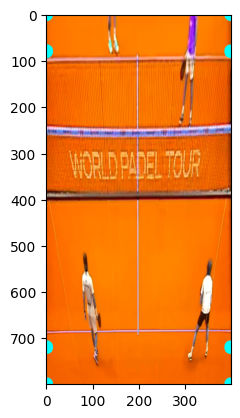

In [106]:
H, status = cv2.findHomography(
    srcPoints=src_points.numpy(), dstPoints=dst_points.numpy()
)
im_src = cv2.imread(file_name, cv2.IMREAD_COLOR)
im_src_t = load_timg(file_name=file_name).squeeze(0)
(h, w) = im_src.shape[:-1]
print(H, status)
im_dst = cv2.warpPerspective(
    im_src,
    H,
    dsize=(400, 800),
    #  ( int(PadelCourt.length*30), int(PadelCourt.width*30))
)
for p1 in src_points[:]:
    # draw_line(image=im_src_t, p1=p1, p2=p2,color=torch.tensor([255, 0, 0]))
    cv2.circle(
        img=im_src,
        center=[int(o) for o in p1],
        radius=25,
        color=(0, 255, 255),
        thickness=20,
    )
plt.imshow(im_src)
for p1 in dst_points[:]:
    # draw_line(image=im_src_t, p1=p1, p2=p2,color=torch.tensor([255, 0, 0]))
    cv2.circle(
        img=im_dst,
        center=[int(o) for o in p1],
        radius=15,
        color=(0, 255, 255),
        thickness=-1,
    )
plt.imshow(np.concatenate([im_dst]))

In [117]:
# Project points
from kornia.geometry.homography import (
    convert_points_from_homogeneous,
    convert_points_to_homogeneous,
)

src_as_dst = convert_points_from_homogeneous(
    convert_points_to_homogeneous(src_points) @ H
)

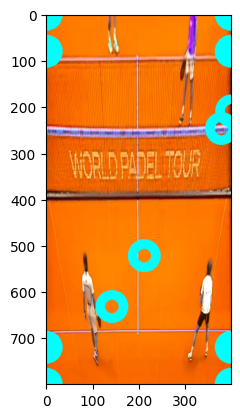

In [119]:
for p1 in src_as_dst[:]:
    # draw_line(image=im_src_t, p1=p1, p2=p2,color=torch.tensor([255, 0, 0]))
    cv2.circle(
        img=im_dst,
        center=[int(o) for o in p1],
        radius=25,
        color=(0, 255, 255),
        thickness=20,
    )
plt.imshow(np.concatenate([im_dst]))

tensor([[ 142.2222,  632.8889],
        [1144.8889,  638.2222],
        [ 401.7778,  209.7778],
        [ 885.3333,  211.5556],
        [ 212.6384,  522.6255],
        [1077.0901,  524.0154],
        [ 379.4137,  247.4131],
        [ 908.3871,  247.5889]], dtype=torch.float64)


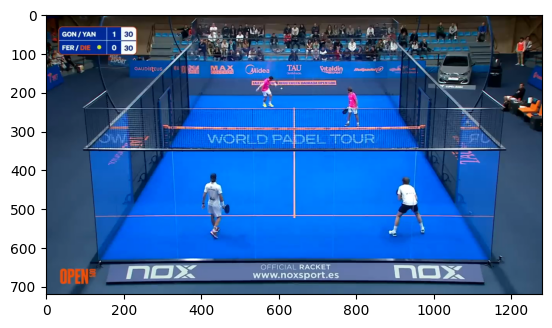

In [108]:
plt.imshow(im_src_t.permute(1, 2, 0))
print(src_points)

In [16]:
from cv2 import getPerspectiveTransform
from kornia.geometry.ransac import RANSAC
from kornia.geometry import (
    homography_warp,
    inverse_transformation,
    rotate,
    normalize_points,
)

model = RANSAC(max_iter=10000, confidence=0.9999)
kp1, _ = normalize_points(src_points.unsqueeze(0))
kp2, _ = normalize_points(dst_points.unsqueeze(0))

# kp1=src_points
# kp2=dst_points

H, mask = model(kp1=kp1.squeeze(0), kp2=kp2.squeeze(0))
print(H)
print(mask)

# dst_points*H

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
tensor([[False],
        [False],
        [False],
        [False]])


In [39]:
from kornia.geometry.homography import find_homography_dlt

H = find_homography_dlt(
    points1=src_points.unsqueeze(0), points2=dst_points.unsqueeze(0)
)

torch.Size([1, 3, 720, 1280])


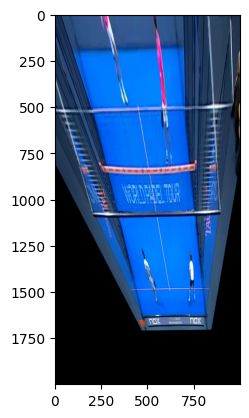

In [44]:
t_img = load_timg(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png"
)
# t_img = rotate(t_img, angle=torch.tensor([180.0]))
width, height = int(PadelCourt.width * 100), int(PadelCourt.length * 100)

print(t_img.shape)

warped = homography_warp(
    patch_src=t_img,
    # src_homo_dst=torch.linalg.inv(H.unsqueeze(0).float()),
    src_homo_dst=H.unsqueeze(0).float(),
    dsize=(height, width),
    align_corners=True,
    normalized_coordinates=True,
    normalized_homography=True,
)
warped.squeeze(0).shape
plt.imshow(t_img.squeeze(0).permute(1, 2, 0))
plt.imshow(rotate(warped, angle=torch.tensor([180.0])).squeeze(0).permute(1, 2, 0))
plt.imshow(warped.squeeze(0).permute(1, 2, 0))

In [47]:
src_img = torch.from_numpy(
    points_to_heat_map(
        named_points=src_corners,
        height=int(PadelCourt.length),
        width=int(PadelCourt.width),
        normalised=True,
    )
)
dst_img = torch.from_numpy(
    points_to_heat_map(
        named_points=dst_corners,
        height=int(PadelCourt.length),
        width=int(PadelCourt.width),
        normalised=True,
    )
)
print(src_img.shape)

plt.imshow(np.concatenate([dst_img, src_img], axis=1))

KeyError: 0

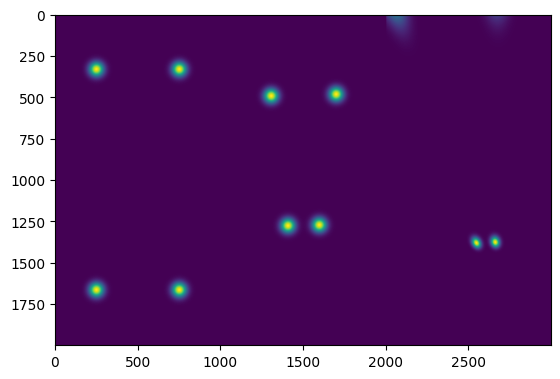

In [46]:
warped = homography_warp(
    patch_src=src_img.unsqueeze(0).unsqueeze(0),
    # src_homo_dst=torch.linalg.inv(H.unsqueeze(0).float()),
    src_homo_dst=H.unsqueeze(0).float(),
    dsize=(height, width),
    align_corners=True,
    normalized_coordinates=True,
    # normalized_homography=True,
)
warped.squeeze(0).shape
plt.imshow(t_img.squeeze(0).permute(1, 2, 0))
plt.imshow(warped.squeeze(0).permute(1, 2, 0))
plt.imshow(
    np.concatenate(
        [dst_img, src_img, warped.squeeze(0).permute(1, 2, 0).squeeze(-1)], axis=1
    )
)

In [184]:
import os

import cv2
import imageio
import torch

import kornia as K
import kornia.geometry as KG


def load_timg(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor."""
    assert os.path.isfile(file_name), f"Invalid file {file_name}"  # nosec
    # load image with OpenCV
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    # convert image to torch tensor
    tensor = K.image_to_tensor(img, None).float() / 255.0
    return K.color.bgr_to_rgb(tensor)


registrator = KG.ImageRegistrator(
    "homography", num_iterations=100000, tolerance=0.0000000001
)

# src_img_t=torch.tensor(src_img.unsqueeze(0).unsqueeze(0), dtype=torch.float)
# dst_image_t=torch.tensor(dst_image.unsqueeze(0).unsqueeze(0).double(), dtype=torch.float)
src_img_t = dst_image.unsqueeze(0).unsqueeze(0)
# dst_image_t=KG.transform.rotate(dst_image.unsqueeze(0).unsqueeze(0), angle=torch.tensor([20.0]))
dst_image_t = KG.transform.rotate(
    dst_image.unsqueeze(0).unsqueeze(0), angle=torch.tensor([30.0])
)
# src_img_t=load_timg("/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png")
# dst_image_t=load_timg("/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0040.png")
src_img_t.shape, dst_image_t.shape

(torch.Size([1, 1, 2000, 1000]), torch.Size([1, 1, 2000, 1000]))

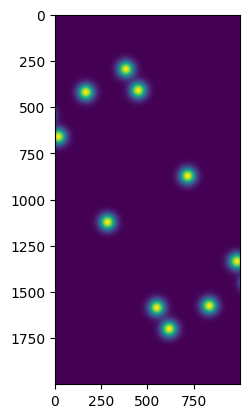

In [185]:
# dst_image_t.shape, torch.DoubleTensor(src_img.unsqueeze(0))
# torch.DoubleTensor(src_img_t)
# plt.imshow(src_img)
plt.imshow(dst_image_t.squeeze(0).squeeze(0))

In [188]:
model, intermediate = registrator.register(
    src_img=src_img_t, dst_img=dst_image_t, output_intermediate_models=True
)

video_writer = imageio.get_writer("medical_registration.gif", fps=2)

timg_dst_first = src_img_t.clone()
timg_dst_first[0, 0, :, :] = timg_dst_first[0, 0, :, :] + dst_image_t[0, 0, :, :]
timg_dst_first = timg_dst_first / timg_dst_first.max()
video_writer.append_data(K.tensor_to_image((timg_dst_first * 255.0).byte()))

with torch.no_grad():
    for m in intermediate:
        timg_dst = KG.homography_warp(src_img_t, m, dst_image_t.shape[-2:])
        timg_dst[0, 0, :, :] = timg_dst[0, 0, :, :] + dst_image_t[0, 0, :, :]
        timg_dst = timg_dst / timg_dst.max()
        video_writer.append_data(K.tensor_to_image((timg_dst * 255.0).byte()))
video_writer.close()

tensor(1.)

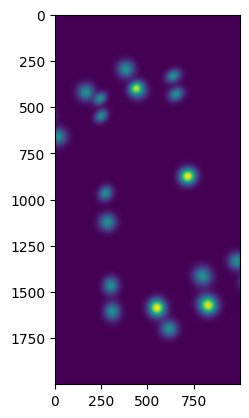

In [189]:
plt.imshow(timg_dst.squeeze(0).squeeze(0))
timg_dst.max()

In [175]:
dst_coords = np.array(
    [
        corners_world["a_front_left"],
        corners_world["b_front_right"],
        corners_world["c_back_left"],
        corners_world["d_back_right"],
        corners_world["e_left_near_serve_line"],
        corners_world["f_right_near_serve_line"],
        corners_world["g_left_far_serve_line"],
        corners_world["h_right_far_serve_line"],
    ],
    dtype=np.float32,
)

dst_coords_norm = np.array(
    [
        corners_world_n["a_front_left"],
        corners_world_n["b_front_right"],
        corners_world_n["c_back_left"],
        corners_world_n["d_back_right"],
        corners_world_n["e_left_near_serve_line"],
        corners_world_n["f_right_near_serve_line"],
        corners_world_n["g_left_far_serve_line"],
        corners_world_n["h_right_far_serve_line"],
    ],
    dtype=np.float32,
)
dst_coords, dst_coords_norm.shape

NameError: name 'corners_world_n' is not defined

In [113]:
import cv2
import numpy as np

# Load the input image
img = cv2.imread(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/frame_0001.png"
)
height, width, _ = img.shape
corners_image = {
    "front_left": ((11.11111111111111 / 100.0), (87.90123456790124 / 100.0)),
    "front_right": ((89.44444444444444 / 100.0), (88.64197530864197 / 100.0)),
    "back_left": ((31.38888888888889 / 100.0), (29.135802469135804 / 100.0)),
    "back_right": ((69.16666666666667 / 100.0), (29.382716049382715 / 100.0)),
    "left_near_serve_line": ((16.61237785016286 / 100.0), (72.58687258687259 / 100.0)),
    "right_near_serve_line": ((84.14766558089035 / 100.0), (72.77992277992279 / 100.0)),
    "left_far_serve_line": ((29.641693811074916 / 100.0), (34.36293436293436 / 100.0)),
    "right_far_serve_line": ((70.96774193548387 / 100.0), (34.387351778656125 / 100.0)),
}
# Define the source and destination coordinates
src_coords = np.array(
    [
        (
            corners_image["front_left"][0] * width,
            corners_image["front_left"][1] * height,
        ),
        (corners_image["back_left"][0] * width, corners_image["back_left"][1] * height),
        (
            corners_image["back_right"][0] * width,
            corners_image["back_right"][1] * height,
        ),
        (
            corners_image["front_right"][0] * width,
            corners_image["front_right"][1] * height,
        ),
        (
            corners_image["left_near_serve_line"][0] * width,
            corners_image["left_near_serve_line"][1] * height,
        ),
        (
            corners_image["right_near_serve_line"][0] * width,
            corners_image["right_near_serve_line"][1] * height,
        ),
        (
            corners_image["left_far_serve_line"][0] * width,
            corners_image["left_far_serve_line"][1] * height,
        ),
        (
            corners_image["right_far_serve_line"][0] * width,
            corners_image["right_far_serve_line"][1] * height,
        ),
    ],
    dtype=np.float32,
)


# plot_coords(img=img, src_coords=src_coords)
from kornia.geometry import denormalize_pixel_coordinates, normalize_pixel_coordinates
import torch

src_coords_norm = normalize_pixel_coordinates(
    torch.tensor(src_coords), height=height, width=width
).numpy()
# dst_coords_norm = normalize_pixel_coordinates(torch.tensor(dst_coords_norm), height=1.0, width=1.0)
# src_coords_norm = torch.tensor(src_coords)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

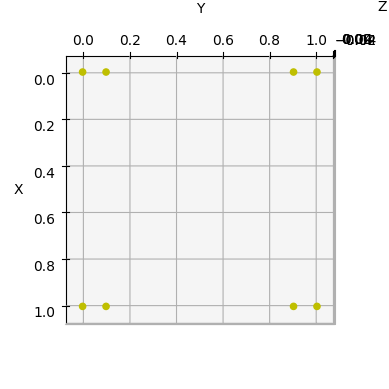

In [87]:
import cv2
import numpy as np

# Define object points in 3D space
# object_points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]], dtype=np.float32)
dst_coords_3d = np.array(
    [
        corners_world_3d_n["b_front_right"],
        corners_world_3d_n["a_front_left"],
        corners_world_3d_n["c_back_left"],
        corners_world_3d_n["d_back_right"],
        corners_world_3d_n["e_left_near_serve_line"],
        corners_world_3d_n["f_right_near_serve_line"],
        corners_world_3d_n["g_left_far_serve_line"],
        corners_world_3d_n["h_right_far_serve_line"],
    ],
    dtype=np.float32,
)
x = dst_coords_3d[:, 0]
y = dst_coords_3d[:, 1]
z = dst_coords_3d[:, 2]
plot_3d_points(x=x, y=y, z=z, colors=["g", "y", "black", "b", "r"])

Intrinsic matrix:
 [[1.07753026e+03 0.00000000e+00 3.59813515e+02]
 [0.00000000e+00 6.06884234e+02 6.39386863e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[-3.46158650e-04 -4.34803545e-05  1.07547143e-04 -3.97959023e-04
   4.80853810e-04]]


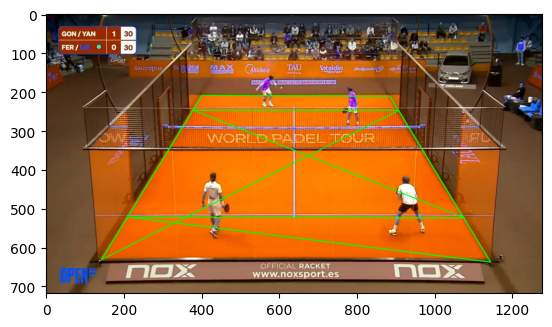

In [93]:
height, width = img.shape[:2]
# Compute intrinsic matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    [dst_coords_3d], [src_coords_norm], img.shape[:2], None, None
)

# Print intrinsic matrix and distortion coefficients
print("Intrinsic matrix:\n", mtx)
print("Distortion coefficients:\n", dist)


def undistort_image(image, intrinsic_matrix, distortion_coeffs):
    # Compute optimal camera matrix
    # width, height = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
        intrinsic_matrix, distortion_coeffs, (width, height), 1, (width, height)
    )

    # Undistort image
    undistorted_image = cv2.undistort(
        image, intrinsic_matrix, distortion_coeffs, None, new_camera_matrix
    )

    # Crop image to remove black border
    x, y, w, h = roi
    # undistorted_image = undistorted_image[y:y+h, x:x+w]

    return undistorted_image[y : y + h, x : x + w]


und_img = undistort_image(image=img, intrinsic_matrix=mtx, distortion_coeffs=dist)
plot_coords(img=und_img, src_coords=src_coords)
import matplotlib.pyplot as plt

plt.imshow(und_img)

In [89]:
rvecs

(array([[-2.33510657],
        [-1.40019402],
        [-0.16447382]]),)

In [90]:
mean_error = 0
[dst_coords_3d], [src_coords_norm]
# for i in range(len(dst_coords_3d)):
imgpoints2, _ = cv2.projectPoints(dst_coords_3d, rvecs[0], tvecs[0], mtx, dist)
error = cv2.norm(src_coords_norm, imgpoints2.reshape(8, 2), cv2.NORM_L2) / len(
    imgpoints2
)

# src_coords_norm.shape, imgpoints2.reshape(4,2).shape
# mean_error += error
# print( "total error: {}".format(mean_error/len(dst_coords_3d)) )
error

0.19525294398230109

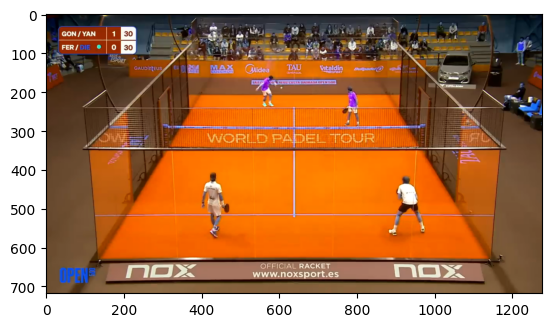

In [91]:
# points_src/points_src.max()
t_img = K.utils.image_to_tensor(und_img).float().unsqueeze(0)
t_img.shape
plt.imshow(und_img)

In [92]:
dst_coords_3d[:, :-1], torch.tensor(src_coords_norm)

(array([[1. , 0. ],
        [0. , 0. ],
        [0. , 1. ],
        [1. , 1. ],
        [0. , 0.1],
        [1. , 0.1],
        [0. , 0.9],
        [1. , 0.9]], dtype=float32),
 tensor([[-0.7776,  0.7605],
         [-0.3717, -0.4165],
         [ 0.3844, -0.4115],
         [ 0.7903,  0.7753],
         [-0.6675,  0.4538],
         [ 0.6843,  0.4576],
         [-0.4067, -0.3118],
         [ 0.4205, -0.3113]]))

In [61]:
# M: torch.tensor = K.geometry.get_perspective_transform(points_src, points_dst)
from kornia.geometry.transform.imgwarp import homography_warp

# dst_coords_3d_n = normalize_pixel_coordinates(torch.tensor(dst_coords_3d[:, :-1]), height=1.0, width=1.0)
m_homography = K.geometry.ransac.RANSAC()
H, d = m_homography(torch.tensor(src_coords_norm), torch.tensor(dst_coords_norm))
warped = homography_warp(
    patch_src=t_img,
    src_homo_dst=H.unsqueeze(0),
    dsize=(width, height),
    align_corners=True,
    normalized_coordinates=True,
    normalized_homography=False,
)
H, d

NameError: name 'src_coords_norm' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


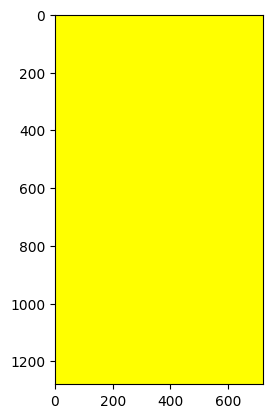

In [84]:
# warped = warper(t_img, H.unsqueeze(0))
plt.imshow(K.tensor_to_image(warped))

In [116]:
# # warp the original image by the found transform
# img_warp: torch.tensor = K.geometry.warp_perspective(img.float(), M, dsize=(h, w))
dd = convert_corners_to_vec(corners_world_n)
dst_points = np.array([(x, y) for x, y in zip(dd["x"], dd["y"])])
dst_points = np.array(
    [
        corners_world_n["b_front_right"],
        corners_world_n["a_front_left"],
        corners_world_n["c_back_left"],
        corners_world_n["d_back_right"],
        corners_world_n["e_left_near_serve_line"],
        corners_world_n["f_right_near_serve_line"],
        corners_world_n["g_left_far_serve_line"],
        corners_world_n["h_right_far_serve_line"],
    ],
    dtype=np.float32,
)

In [119]:
rvecs

(array([[-2.33510657],
        [-1.40019402],
        [-0.16447382]]),)

In [145]:
import numpy as np
import cv2

# Assuming you have rotation vector rvecs and translation vector tvecs
# rvecs = np.array([[theta_x], [theta_y], [theta_z]])
# tvecs = np.array([[tx], [ty], [tz]])

# Convert the rotation vector to a rotation matrix using Rodrigues()
R, _ = cv2.Rodrigues(rvecs[0])

# Combine the rotation and translation matrices
RT = np.hstack((R, tvecs[0]))

# Add a row of [0, 0, 0, 1] to the bottom of the RT matrix
RT = np.vstack((RT, [0, 0, 0, 1]))

# Create a homography matrix by multiplying the RT matrix with a diagonal matrix [1, 1, 1, 1]
H = np.dot(np.diag([1, 1, 1, 1]), RT)

# Normalize the homography matrix by dividing by the last element
H = H / H[3, 3]

H_3x3 = H[:3, :3]

# Normalize the homography matrix by dividing by the last element of H_3x3
H_3x3 = H_3x3 / H_3x3[2, 2]
# You can now use the homography matrix to transform points or images
# Note that the rotation vector rvecs should be a 3x1 vector representing the angles of rotation around the x, y, and z axes respectively, and the translation vector tvecs should be a 3x1 vector representing the distance and direction of the translation. The Rodrigues() function converts the rotation vector into a rotation matrix. The resulting homography matrix H is a 4x4 matrix that can be used for perspective transformations.

In [146]:
H_3x3.shape, H_3x3.dtype
# img

((3, 3), dtype('float64'))

array([[ 4.88280255e-01,  8.66031817e-01, -1.07569904e-01,
        -3.91697330e+02],
       [ 8.17530568e-01, -4.10804927e-01,  4.03587763e-01,
        -1.23563532e+03],
       [ 3.05329597e-01, -2.85005620e-01, -9.08595418e-01,
         1.17320042e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

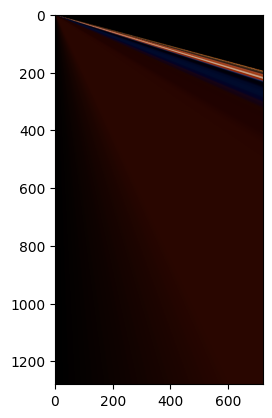

In [147]:
# Find the homography matrix
# H, _ = cv2.findHomography(src_coords, dst_points, method=cv2.RANSAC, maxIters=1000)

# Apply the homography matrix to the input image
output_size = (
    int(PadelCourt.width),
    int(PadelCourt.length),
)  # The size of the output image
output = cv2.warpPerspective(img, H_3x3, (720, 1280))

# Display the output image
plt.imshow(output)
# cv2.imshow('Output', output)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
H

In [137]:
H.shape, H.dtype

((3, 3), dtype('float64'))

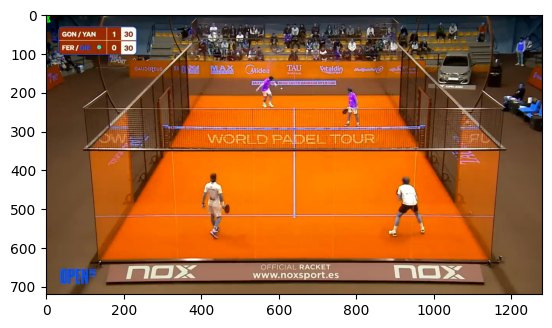

In [16]:
def plot_coords(img: np.array, src_coords: np.array, show: bool = True):
    src_coords = src_coords.astype(int)
    cv2.polylines(img, [src_coords], True, (0, 255, 0), thickness=2)
    plt.imshow(img)


plot_coords(img=img, src_coords=dst_coords)

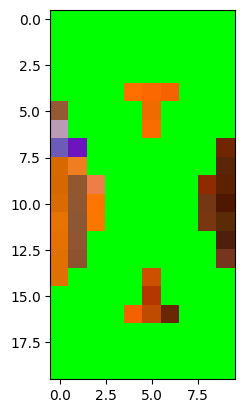

In [17]:
plot_coords(output, dst_coords)

In [15]:
PadelCourt.center_line.shape

(2, 1, 2)

In [16]:
cv2.polylines(output, [PadelCourt.center_line], True, (0, 255, 0), thickness=2)
cv2.polylines(output, [PadelCourt.net_line], True, (0, 255, 0), thickness=2)
cv2.polylines(output, [PadelCourt.near_serve_line], True, (0, 255, 0), thickness=2)
cv2.polylines(output, [PadelCourt.far_serve_line], True, (0, 255, 0), thickness=2)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [186, 166, 217],
        ...,
        [209,  83,   0],
        [209,  82,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [203,  75,   0],
        [197,  71,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [191,  71,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [17]:
dst_coords

array([[  0., 800.],
       [  0.,   0.],
       [400.,   0.],
       [400., 800.],
       [  0., 720.],
       [400., 720.],
       [  0.,  80.],
       [400.,  80.]], dtype=float32)

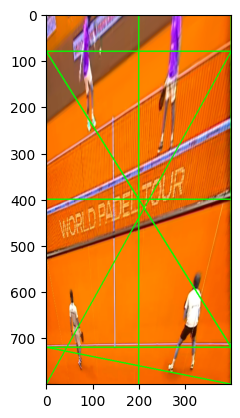

In [18]:
plt.imshow(output)

In [166]:
PadelCourt.far_serve_line

array([[[  0,   2]],

       [[400,   2]]], dtype=int32)

In [49]:
import cv2
import numpy as np

# Define the 2D and 3D coordinates
image_points = np.array([(10, 20), (100, 50), (30, 200)], dtype=np.float32)
world_points = np.array([(0, 0, 0), (1, 0, 0), (0, 1, 0)], dtype=np.float32)

# Compute the camera matrix
_, rvec, tvec = cv2.solvePnP(
    world_points, image_points, np.eye(3, dtype=np.float32), None
)
rot_mat, _ = cv2.Rodrigues(rvec)
cam_mat = np.hstack((rot_mat, tvec))

# Define the image to be placed on the plane
img = cv2.imread("image.jpg")

# Compute the perspective transformation
rows, cols, _ = img.shape
persp_mat = cv2.getPerspectiveTransform(
    np.array(
        [(0, 0), (cols - 1, 0), (0, rows - 1), (cols - 1, rows - 1)], dtype=np.float32
    ),
    cam_mat.dot(world_points.T).T[:, :2],
)

# Apply the perspective transformation and place the image on the plane
result = cv2.warpPerspective(img, persp_mat, (cols, rows))

error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:840: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'
